## Importing Data

In [1]:
import pandas as pd
import numpy as np # Using version 1.16.3 to disable Pandas FutureWarnings
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('candy_production.csv', index_col='observation_date')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 548 entries, 1972-01-01 to 2017-08-01
Data columns (total 1 columns):
IPG3113N    548 non-null float64
dtypes: float64(1)
memory usage: 8.6+ KB


The *observation_date* was not read as Datetime. So let's convert it...

In [4]:
df.index = pd.to_datetime(df.index)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 548 entries, 1972-01-01 to 2017-08-01
Data columns (total 1 columns):
IPG3113N    548 non-null float64
dtypes: float64(1)
memory usage: 8.6 KB


In [6]:
df.head()

,IPG3113N
observation_date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100


In [7]:
df.tail()

,IPG3113N
observation_date,
2017-04-01,107.4288
2017-05-01,101.9209
2017-06-01,104.2022
2017-07-01,102.5861
2017-08-01,114.0613


In [8]:
df.describe()

,IPG3113N
count,548.000000
mean,100.662524
std,18.052931
min,50.668900
25%,87.862475
50%,102.278550
75%,114.691900
max,139.915300


## Data Analysis

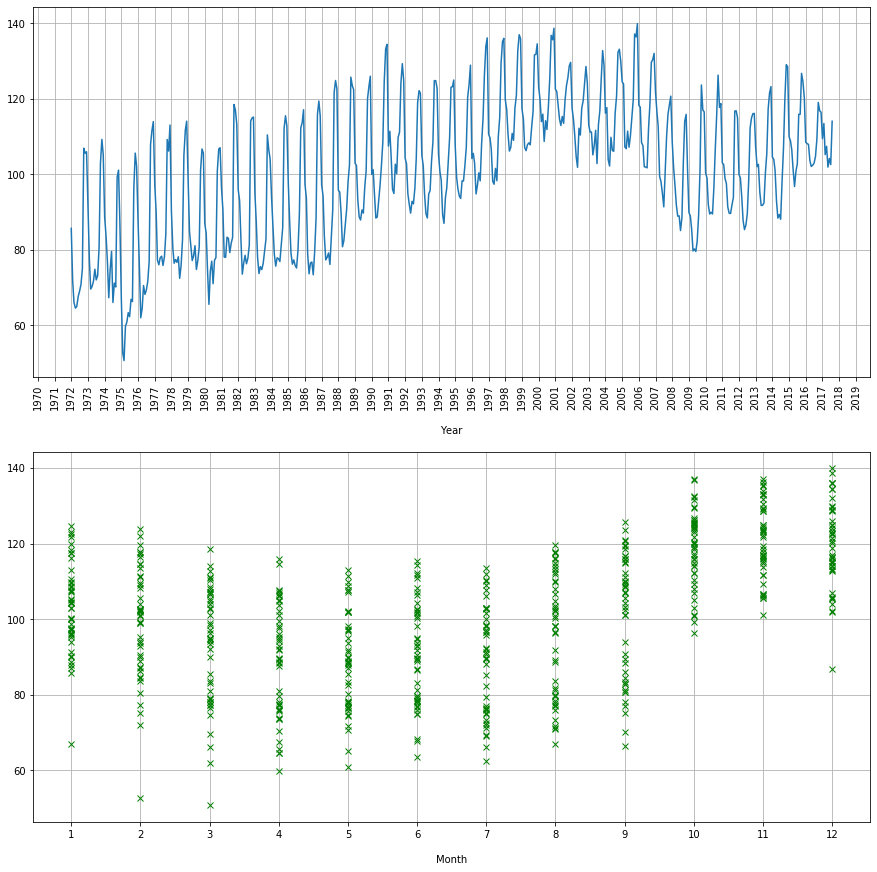

In [9]:
register_matplotlib_converters() # To disable Pandas FutureWarnings

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)
ax1.plot(df)
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
plt.xticks(rotation=90)
ax1.set_xlabel('\nYear')
plt.grid()

ax2 = fig.add_subplot(212)
ax2.plot(df.index.month, df, 'xg')
plt.xticks(np.arange(1,13,1))
ax2.set_xlabel('\nMonth')               
plt.grid()

plt.show()

From the above plots, we can see clearly a **seasonality** in this data.  
So let's build a model to predict a full year (12 months) based on previous values...

## Train/Test Split

In [10]:
train_set = df.head(len(df)-12)
train_set.head()

,IPG3113N
observation_date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100


In [11]:
test_set = df.tail(12)
test_set.head()

,IPG3113N
observation_date,
2016-09-01,109.3191
2016-10-01,119.0502
2016-11-01,116.8431
2016-12-01,116.4535
2017-01-01,109.4666


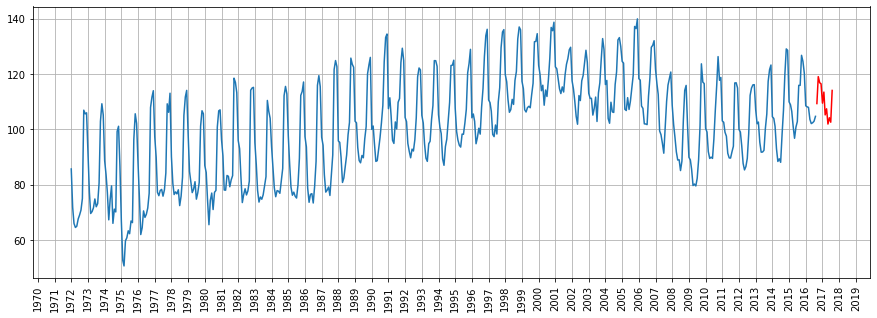

In [12]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(train_set)
ax.plot(test_set, 'r')
ax.xaxis.set_major_locator(years) # Locator and formatter previously defined
ax.xaxis.set_major_formatter(years_fmt)
plt.xticks(rotation=90)
plt.grid()
plt.show()

We will be using the *blue* data to predict the *red* data...

## Scaling Data

In [13]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

In [14]:
train_scaled.shape

(536, 1)

In [15]:
train_scaled[:13] # Shows the first 12 months + 1 (this last one will be used as the target)

array([[0.39245953],
       [0.23699667],
       [0.17204055],
       [0.15569928],
       [0.16069108],
       [0.19023512],
       [0.20587945],
       [0.22598222],
       [0.27314603],
       [0.63038957],
       [0.61545676],
       [0.61961491],
       [0.45526542]])

## Creating Sequences

In [16]:
sequence = []
sequential_data = []

for item in train_scaled:
    sequence.append(item[0])
    if len(sequence) == 13: # 12 + 1 months
        sequential_data.append([np.array(sequence[:-1]), sequence[-1]])
        sequence.pop(0)

sequential_data[0]

[array([0.39245953, 0.23699667, 0.17204055, 0.15569928, 0.16069108,
        0.19023512, 0.20587945, 0.22598222, 0.27314603, 0.63038957,
        0.61545676, 0.61961491]), 0.45526542247082236]

In [17]:
sequential_data = shuffle(sequential_data, random_state=25)  # For better measures

In [18]:
X_train = []
y_train = []

for sequence, target in sequential_data:
    X_train.append(sequence)
    y_train.append(target)

X_train = np.array(X_train)
X_train[0]

array([0.63336   , 0.66718994, 0.71880434, 0.77377127, 0.96923349,
       0.96050149, 1.        , 0.75759582, 0.75238441, 0.64709053,
       0.63766606, 0.5750428 ])

In [19]:
y_train[0]

0.5745172914537728

*X_test* will be determined with the model predictions...

In [20]:
y_test_scaled = test_scaled
y_test_scaled

array([[0.65717161],
       [0.76620794],
       [0.74147753],
       [0.73711209],
       [0.65882433],
       [0.70363847],
       [0.61129188],
       [0.63599092],
       [0.57427526],
       [0.59983708],
       [0.58172879],
       [0.71030764]])

## Building Keras Model (w/ GridSearchCV)

In [21]:
X_train.shape

(524, 12)

In [22]:
samples, timesteps = X_train.shape

In [23]:
X_train = X_train.reshape(samples, timesteps, 1) # (samples, timesteps, features)
X_train.shape

(524, 12, 1)

In [24]:
def gru_model(optimizer):
    model = Sequential()

    model.add(GRU(128, input_shape=X_train.shape[1:], return_sequences=True))
    model.add(Dropout(0.2))

    model.add(GRU(128, return_sequences=True))
    model.add(Dropout(0.1))

    model.add(GRU(32))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='relu'))
    
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mse'])
    
    return model

In [25]:
model = KerasRegressor(build_fn=gru_model, epochs=30)

param_grid = {'optimizer':['RMSprop', 'Adam'],
              'batch_size':[32, 64]}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)

In [26]:
grid_result = grid.fit(X_train, y_train)

W0805 17:09:23.189286 139819697370944 deprecation.py:506] From /home/vinicius/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0805 17:09:24.517548 139819697370944 deprecation.py:323] From /home/vinicius/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
524/524 [==============================] - 2s 4ms/sample - loss: 0.1415 - mean_squared_error: 0.1415
Epoch 2/30
524/524 [==============================] - 1s 1ms/sample - loss: 0.0355 - mean_squared_error: 0.0355
Epoch 3/30
524/524 [==============================] - 1s 1ms/sample - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 4/30
524/524 [==============================] - 1s 1ms/sample - loss: 0.0306 - mean_squared_error: 0.0306
Epoch 5/30
524/524 [==============================] - 1s 1ms/sample - loss: 0.0287 - mean_squared_error: 0.0287
Epoch 6/30
524/524 [==============================] - 1s 1ms/sample - loss: 0.0237 - mean_squared_error: 0.0237
Epoch 7/30
524/524 [==============================] - 1s 1ms/sample - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 8/30
524/524 [==============================] - 1s 2ms/sample - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 9/30
524/524 [==============================] - 1s 2ms/sample - loss: 0.0143 - mean_squared_error:

In [27]:
grid_result.best_params_

{'batch_size': 32, 'optimizer': 'Adam'}

In [28]:
grid_result.best_score_

-0.005979375042845957

## Predicting the next 12 months

In [29]:
test_points = list(train_scaled[-12:])
test_seq = []

for _ in range(12):
    test_seq = np.array(test_points[-12:]).reshape(1, 12, 1)
    test_points.append(grid_result.predict(test_seq).astype(np.float64))
    
test_points

[array([0.73086982]),
 array([0.85241646]),
 array([0.82746979]),
 array([0.77951043]),
 array([0.64803958]),
 array([0.64385678]),
 array([0.64173793]),
 array([0.59329004]),
 array([0.5760759]),
 array([0.57969285]),
 array([0.58581971]),
 array([0.60538912]),
 array(0.68486118),
 array(0.73734802),
 array(0.75502807),
 array(0.74018615),
 array(0.70053148),
 array(0.65804541),
 array(0.61316526),
 array(0.57336497),
 array(0.55011177),
 array(0.54595822),
 array(0.56172293),
 array(0.59730935)]

In [30]:
y_test_predicted = test_points[-12:]
y_test_predicted

[array(0.68486118),
 array(0.73734802),
 array(0.75502807),
 array(0.74018615),
 array(0.70053148),
 array(0.65804541),
 array(0.61316526),
 array(0.57336497),
 array(0.55011177),
 array(0.54595822),
 array(0.56172293),
 array(0.59730935)]

In [31]:
y_test_real = scaler.inverse_transform(y_test_scaled)
y_test_predicted = scaler.inverse_transform(np.array(y_test_predicted).reshape(12,1))

In [32]:
y_test_real

array([[109.3191],
       [119.0502],
       [116.8431],
       [116.4535],
       [109.4666],
       [113.4661],
       [105.2245],
       [107.4288],
       [101.9209],
       [104.2022],
       [102.5861],
       [114.0613]])

In [33]:
y_test_predicted

array([[111.7902951 ],
       [116.47455634],
       [118.05243706],
       [116.72784965],
       [113.18881292],
       [109.39708398],
       [105.391692  ],
       [101.83965973],
       [ 99.76439513],
       [ 99.39370577],
       [100.80064968],
       [103.97660926]])

In [34]:
df_final = pd.DataFrame(index=test_set.index)
df_final['real'] = y_test_real
df_final['predicted'] = y_test_predicted

In [35]:
df_final

,real,predicted
observation_date,,
2016-09-01,109.3191,111.790295
2016-10-01,119.0502,116.474556
2016-11-01,116.8431,118.052437
2016-12-01,116.4535,116.727850
2017-01-01,109.4666,113.188813
2017-02-01,113.4661,109.397084
2017-03-01,105.2245,105.391692
2017-04-01,107.4288,101.839660
2017-05-01,101.9209,99.764395


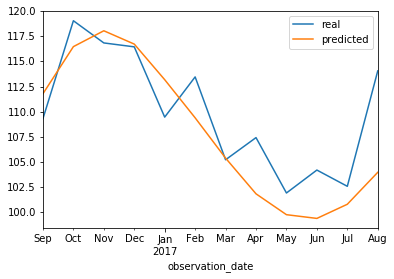

In [36]:
df_final.plot()